In [7]:
import io
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
import torch
import torch.nn as nn
import csv
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
# !pip install transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# %cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


## Loading dataset

Either NNSeval or BenchLS

In [3]:
def load_dataset(data_fname): # either NNSeval or BenchLS
    database = dict()
    with open(data_fname,'rt') as f:
        for line in f:
            data = line.strip().split('\t')
            replacement_ranking = dict()
            for rep in data[3:]:
                rank_rep = rep.split(':')
                replacement_ranking[rank_rep[1]] = int(rank_rep[0])
            
            database[data[0]] = (data[1], replacement_ranking)

    print('loaded dataset {}'.format(data_fname))
    print('Database has {} samples'.format(len(database)))
    key0 = list(database.keys())[0]
    print('Sample for example:\n  ',key0, '\n')
    print('Candidate for replacement and options ranking:\n  ', database[key0])
    
    return database

In [ ]:
def load_LexMTurk(data_fname):
    database = dict()
    with open(data_fname,'rt', encoding='iso8859-1') as f:
        # for line in f:
        for line in itertools.islice(f, 1, 501):
            # print(line)
            data = line.strip().split('\t')
            reps = list(set(data[3:]))
            database[data[0]] = (data[1], reps)

    print('loaded dataset {}'.format(data_fname))
    print('Database has {} samples'.format(len(database)))
    key0 = list(database.keys())[0]
    print('Sample for example:\n  ',key0, '\n')
    print('Candidate for replacement and options ranking:\n  ', database[key0])
    
    return database

For now, let's load NNSeval:

In [4]:
database = load_dataset('./NLP_final_project/NNSeval.txt')

loaded dataset ./NLP_final_project/NNSeval.txt
Database has 239 samples
Sample for example:
   harry also becomes the worthy possessor of the remaining deathly hallows : the invisibility cloak and the resurrection stone , hence becoming the true master of death . 

Candidate for replacement and options ranking:
   ('possessor', {'owner': 1, 'holder': 2, 'buyer': 3, 'master': 3, 'teacher': 3})


## Load embedding

Either Glove or Fasttext

In [5]:
def load_embedding(embedding = 'fasttext'):
  embeddings_index = dict()
  if embedding == 'fasttext':
    start = 1 # file has title row
    fname = './NLP_final_project/crawl-300d-2M.vec'
  elif embedding == 'glove':
    start = 0
    fname = './NLP_final_project/glove.6B.300d.txt'
  else:
    print('No such embedding')
    return

  with open(fname,'rt', encoding='utf8') as f:
    for line in itertools.islice(f, start, 400000 + start):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  return embeddings_index

**Let's load fasttext to be able to play a little**

In [8]:
embeddings_index = load_embedding('fasttext')
all_embeddings = np.stack(list(embeddings_index.values()))
vocab = np.array(list(embeddings_index.keys()))
all_norm = norm(all_embeddings, axis=1)

Create some global lists and confirm all our candidates are in the embedded space:

In [9]:
# Some global lists
candidates = []
sug_words = []
count_out_of_emb = 0
keys_to_remove = []
for i, key in enumerate(database.keys()):
    candidate, reps = database[key]
    if candidate in embeddings_index.keys():
      candidates.append(candidate)
      sug_words.append(reps)
    else:
      keys_to_remove.append(key)
      count_out_of_emb += 1
if count_out_of_emb:
    print(f'{count_out_of_emb} candidates are not in the embedding vocabulary')
else:
    print('All candidates are represented in the embedding vocabulary')

for key in keys_to_remove:
  database.pop(key)

All candidates are represented in the embedding vocabulary


### General helper functions for similarities and distances

In [10]:
def cos_similarity(a, b):
    cosine = np.dot(a, b)/(norm(a)*norm(b))
    return cosine

In [11]:
def L2_similarity(a, b):
    l2 = np.sqrt(np.sum((a-b)**2))
    return l2

In [12]:
def compute_all_distances(all_embeddings, word_emb):
    dists = np.sqrt(np.sum((all_embeddings - word_emb)**2, axis = 1))
    return dists

In [13]:
def compute_all_cosines(all_embeddings, word_emb):
    # all_norm = norm(all_embeddings, axis=1)
    all_embeddings = all_embeddings/np.expand_dims(all_norm, axis = 1)
    word_emb = word_emb/norm(word_emb)
    all_cosines = all_embeddings@word_emb
    return all_cosines

In [14]:
def word_relations(word1, word2):
    vec1 = embeddings_index[word1]
    vec2 = embeddings_index[word2]
    print(word1, 'norm is: ', norm(vec1))
    print(word2, 'norm is: ', norm(vec2))
    print('cosine similarity is: ',cos_similarity(vec1, vec2))
    print('Euclidian distance is: ',L2_similarity(vec1, vec2))

In [15]:
def compute_all_similarities(all_embeddings, add_dist = True):
    all_dist = {}
    all_cos = {}
    for candidate in candidates:
        word_emb = embeddings_index[candidate]     
        cosines = compute_all_cosines(all_embeddings, word_emb)
        all_cos[candidate] = cosines
        if add_dist:
          dists = compute_all_distances(all_embeddings, word_emb)
          all_dist[candidate] = dists

    # return all_cos
    return all_dist, all_cos

In [ ]:
all_dist, all_cos = compute_all_similarities(all_embeddings)

In [ ]:
def find_closest_words_from_embedding(dists, cosines, candidate, n, add_dist = True):   
    ind_dist = np.array([]).astype(int)
    ind_cos = np.argsort(cosines)[::-1][1:n]
    if add_dist:
      ind_dist = np.argsort(dists)[1:n] 
    ind = np.union1d(ind_dist, ind_cos)
    limited_vocab = vocab[ind]

    return limited_vocab

In [ ]:
def compute_model_suggested_n(all_embeddings, n_list, add_dist = True):
  model_suggested_n = {}
  for n in n_list:
      sugg_fixed_n = {}
      for candidate in set(candidates):
          cosines = all_cos[candidate]
          if add_dist:
            dists = all_dist[candidate]
          else:
            dists = np.array([])
          # limited_vocab = find_closest_words_from_embedding(cosines, candidate, n)
          limited_vocab = find_closest_words_from_embedding(dists, cosines, candidate, n, add_dist)
          sugg_fixed_n[candidate] = limited_vocab
      model_suggested_n[n] = sugg_fixed_n

  return model_suggested_n

The next function evaluates the potential coverage of the dataset suggested replacements, by the model's suggested replacments.\
If the model doesn't suggested even one of the dataset replacements, the function counts non matches. For the rest, it calculates the percentage of words covered per each instance, and finally returns the mean for all instances.\
With increasing n, we can see how our coverage improves. We can also compare between Glove and Fasttext.

In [ ]:
def evaluate_embedding_coverage(model_suggested_n):
    mean_score = np.zeros((len(n_list)))
    no_matches_n = np.zeros((len(n_list)))

    for ms, n in enumerate(n_list):
        score = np.zeros((len(database)))
        count_no_matches = 0
        sugg_fixed_n = model_suggested_n[n]
        for i, candidate in enumerate(candidates):
            suggested_words = sug_words[i]
            limited_vocab = sugg_fixed_n[candidate]
            counter = 0
            for rep in suggested_words:
                if rep in limited_vocab:
                    counter +=1
            if counter == 0:
                count_no_matches+=1
            score[i] = counter/len(suggested_words)
        no_matches_n[ms] = count_no_matches
        mean_score[ms] = np.mean(score)
        
    return mean_score, no_matches_n

## Compare fasttext to glove

In [ ]:
embeddings = ['fasttext', 'glove']
add_dist = True
n_list = [50, 100, 150, 200, 350, 500, 750]

for space in embeddings:
  embeddings_index = load_embedding(space)
  all_embeddings = np.stack(list(embeddings_index.values()))
  vocab = np.array(list(embeddings_index.keys()))
  all_norm = norm(all_embeddings, axis=1)
  all_dist, all_cos = compute_all_similarities(all_embeddings, add_dist)
  model_suggested_n = compute_model_suggested_n(all_embeddings, n_list)
  mean_score, no_matches_n = evaluate_embedding_coverage(model_suggested_n)
  path = './NLP_final_project/model_suggested_n_' + space
  with open(path, 'wb') as f:
    pickle.dump((n_list, model_suggested_n, mean_score, no_matches_n), f)

In [ ]:
path = './NLP_final_project/model_suggested_n_fasttext'

with open(path, 'rb') as f:
  n_list, model_suggested_n, mean_score, no_matches_n = pickle.load(f)
  print('loaded model replacements candidates')

In [ ]:
def plot_coverage_evaluation(path_prefix, options, labels):
  colors = ['.-b', '.-r']
  fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  for option, color, label in zip(options, colors, labels):
    # path = './NLP_final_project/model_suggested_n_' + option
    path = path_prefix + option

    with open(path, 'rb') as f:
      n_list, model_suggested_n, mean_score, no_matches_n = pickle.load(f)
    
    ax1.plot(n_list, mean_score, color, ms = 12, label = label)
    ax2.plot(n_list, no_matches_n, color, ms = 12, label = label)
  
  ax1.set_xlabel('Number of top words', fontsize = 12)
  ax1.set_ylabel('%')
  ax1.set_title('Average percent of coverage - Recall')
  ax1.legend(fontsize = 16)
  ax1.grid('visible')

  ax2.set_xlabel('Number of top words', fontsize = 12)
  ax2.set_ylabel('#')
  ax2.set_title('Number of candidates with 0 coverage \n of dataset suggested words')
  ax2.legend(fontsize = 14)
  ax2.grid('visible')


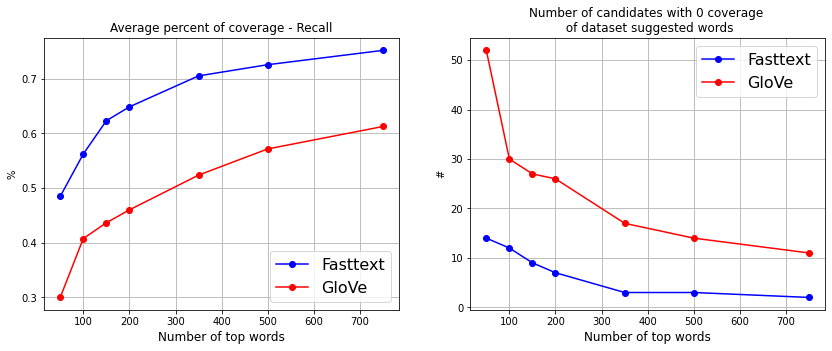

In [ ]:
path_prefix = './NLP_final_project/model_suggested_n_'
options = ['fasttext', 'glove']
labels = ['Fasttext', 'GloVe']
plot_coverage_evaluation(path_prefix, options, labels)

## Advantage in using L2 similarity

In [ ]:
add_distance = [False, True]
n_list = [50, 100, 150, 200, 350, 500, 750]
embeddings_index = load_embedding('fasttext')
all_embeddings = np.stack(list(embeddings_index.values()))
vocab = np.array(list(embeddings_index.keys()))
all_norm = norm(all_embeddings, axis=1)

for add_dist in add_distance:
  all_dist, all_cos = compute_all_similarities(all_embeddings, add_dist)
  model_suggested_n = compute_model_suggested_n(all_embeddings, n_list, add_dist)
  mean_score, no_matches_n = evaluate_embedding_coverage(model_suggested_n)
  path = './NLP_final_project/model_suggested_n_add_dist_' + str(add_dist)
  with open(path, 'wb') as f:
    pickle.dump((n_list, model_suggested_n, mean_score, no_matches_n), f)


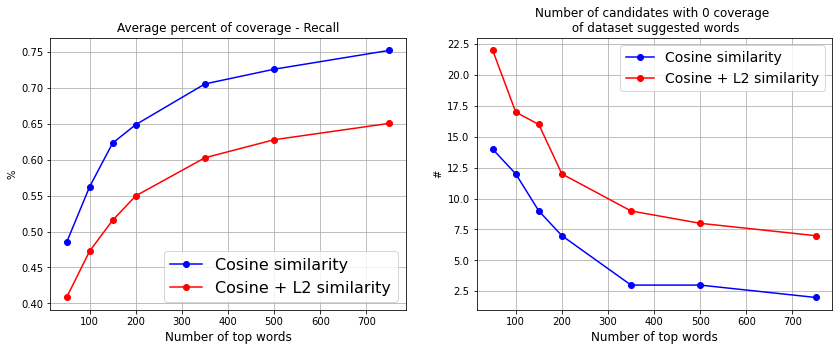

In [ ]:
path_prefix = './NLP_final_project/model_suggested_n_add_dist_'
options = ['True', 'False']
labels = ['Cosine similarity', 'Cosine + L2 similarity']
plot_coverage_evaluation(path_prefix, options, labels)

## Stage 2 - Filtering by pos tagging and lemmatization

In [16]:
path = './NLP_final_project/model_suggested_n_fasttext'

with open(path, 'rb') as f:
  n_list, model_suggested_n, mean_score, no_matches_n = pickle.load(f)

In [17]:
n_list

[50, 100, 150, 200, 350, 500, 750]

In [18]:
def filter_by_pos(sentence, candidate, reps):
    text = word_tokenize(sentence)  # nltk tokenization
    word_idx = text.index(candidate)
    tagged = pos_tag(text)
    filtered_same_pos = []
    for r in reps:
        rep_sentence = sentence.replace(candidate, r)
        rep_text = word_tokenize(rep_sentence)
        rep_tagged = pos_tag(rep_text)
        if rep_tagged[word_idx][1] == tagged[word_idx][1]:
            filtered_same_pos.append(r)
    return filtered_same_pos

In [19]:
sentence = 'escapologists escape from handcuffs , straitjackets , cages , coffins , steel boxes , barrels , bags , burning buildings , fish-tanks and other perils , often in combination .'
word = 'perils'
limited_vocab = model_suggested_n[100]['perils']
filtered_vocab = filter_by_pos(sentence, word, limited_vocab)

In [21]:
ps = PorterStemmer()
def filter_by_lemma(candidate, reps):
    filtered_for_stem = []
    candidate_token = word_tokenize(candidate)
    candidate_stem = ps.stem(candidate_token[0])
    # print(candidate_stem)
    for rep in reps:
        rep_stem = ps.stem(rep)
        # print(rep_stem)
        if rep_stem != candidate_stem:
            filtered_for_stem.append(rep)
    
    return filtered_for_stem

Fasttext contain the upper case as well, but this is taken care of by lemma filtering.

Since we are already transfering to context filtering, keys will be sentences from now on.

In [ ]:
model_suggested_n_filtered = dict()
ns = sorted(model_suggested_n.keys())
n_max = max(ns)
for i, sentence in enumerate(database.keys()):
    candidate = candidates[i]
    limited_vocab = model_suggested_n[n_max][candidate]
    filtered_pos = filter_by_pos(sentence, candidate, limited_vocab)
    filtered_lemma = filter_by_lemma(candidate, filtered_pos)
    # model_suggested_n_filtered[n_max][candidate] = filtered_lemma
    model_suggested_n_filtered.setdefault(n_max, dict())[sentence] = filtered_lemma
    for n in ns[:-1]:
        limited_vocab = model_suggested_n[n][candidate]
        n_filtered = [word for word in limited_vocab if word in filtered_lemma] # intersection between suggested and filtered of maximal length
        model_suggested_n_filtered.setdefault(n, dict())[sentence] = n_filtered

path = './NLP_final_project/model_suggested_n_filtered'
with open(path, 'wb') as f:
  pickle.dump((ns, model_suggested_n_filtered), f)

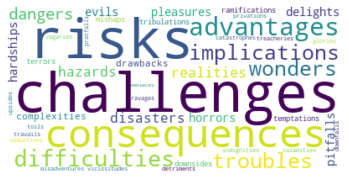

In [ ]:
sentence = 'escapologists escape from handcuffs , straitjackets , cages , coffins , steel boxes , barrels , bags , burning buildings , fish-tanks and other perils , often in combination .'
word = 'perils'
limited_vocab = model_suggested_n[50]['perils']
filtered_vocab = filter_by_pos(sentence, word, limited_vocab)
left_out = [w for w in limited_vocab if w not in filtered_vocab]
from wordcloud import WordCloud
text = " ".join(filtered_vocab)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

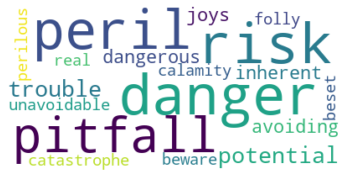

In [ ]:
text2 = " ".join(left_out)
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
path = './NLP_final_project/model_suggested_n_filtered'
with open(path, 'rb') as f:
  ns, model_suggested_n_filtered = pickle.load(f)

In [ ]:
filter_percent = np.zeros((len(ns)))
for j, n in enumerate(ns):
  sug_dict_filt = model_suggested_n_filtered[n]
  sug_dict = model_suggested_n[n]
  sum_percent = 0
  for i, sentence in enumerate(database.keys()):
    candidate = candidates[i]
    list_n = sug_dict[candidate]
    list_n_filt = sug_dict_filt[sentence]
    sum_percent += len(list_n_filt)/len(list_n)
  filter_percent[j] = 1-sum_percent/len(database)

In [ ]:
filter_percent

array([0.4491119 , 0.47299571, 0.48611071, 0.49581899, 0.51391443,
       0.52505834, 0.53657276])

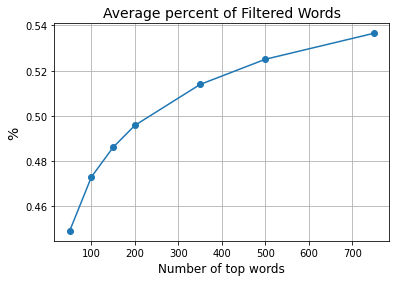

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6, 4))
  
ax1.plot(ns, filter_percent, '.-', ms = 12)

ax1.set_xlabel('Number of top words', fontsize = 12)
ax1.set_ylabel('%', fontsize = 14)
ax1.set_title('Average percent of Filtered Words', fontsize = 14)
# ax1.legend(fontsize = 16)
ax1.grid('visible')

## Stage 3 - BERT

Processing inspired by: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/ 

In [34]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.3 MB/s 
     |████████████████████████████████| 101 kB 9.7 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [35]:
from transformers import BertModel, BertConfig
from transformers import BertTokenizer

In [36]:
base_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(base_model_name)
config = BertConfig.from_pretrained(base_model_name)
model = BertModel.from_pretrained(base_model_name, config = config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load frequency list

In [37]:
with open('./NLP_final_project/unigram_freq.csv', mode='r') as f:
    frequencies = []
    word_freq = {}
    reader = csv.reader(f)
    column = next(reader)
    for row in reader:
        word_freq[row[0]] = int(row[1])
        frequencies.append(int(row[1]))

In [ ]:
print(list(word_freq.keys())[:10])

['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']


In [38]:
def sum_4_last(token_embeddings):
    token_vecs = []
    for token in token_embeddings:
        # cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs.append(sum_vec)
    return token_vecs

In [39]:
def concat_4_last(token_embeddings):
    token_vecs = []
    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        token_vecs.append(cat_vec)
    return token_vecs

In [40]:
def return_cls(token_embeddings):
    return token_embeddings[0][-1]

In [41]:
def bert_semantic_representation(sentence, function):
    #This is how Bert will treat the sentence tokenization
    formatted_text = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(formatted_text)

    input_ids = tokenizer.encode(text=sentence, 
                                  add_special_tokens=True,
                                  max_length=100,
                                  truncation=True,
                                  padding=False)

    attn_mask = [1] * len(input_ids)
    input_ids_batch = torch.unsqueeze(torch.tensor(input_ids), 0)
    attn_mask_batch = torch.unsqueeze(torch.tensor(attn_mask), 0)

    model.eval()
    with torch.no_grad():
        bert_result = model(input_ids_batch, 
                      token_type_ids=None, 
                      attention_mask=attn_mask_batch, 
                      output_hidden_states = True,
                      return_dict = False)
        hidden_states = bert_result[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)

        rep_vec = function(token_embeddings)

    return rep_vec

In [42]:
def subfinder(tokens_list, target_list):
    #returns first match
    for i in range(len(tokens_list)):
        if tokens_list[i] == target_list[0] and tokens_list[i:i+len(target_list)] == target_list:
            break
    return i

Here we define our cutoff word-frequency for simplification.\
The top 4% of the words are above 3195104 apearances in the curpus...

In [43]:
len_freq_dict = len(word_freq)
percent = 0.04
freq_ind = int(percent*len_freq_dict)
threshold = frequencies[freq_ind]
print(threshold)

3195104


In [44]:
def bert_rated_sugg(sentence, candidate, reps):
    formatted_text = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(formatted_text)
    target_list = tokenizer.tokenize(candidate)
    start_ind = subfinder(tokenized_text, target_list)
    end_ind = start_ind + len(target_list)
    original_hidden = torch.sum(torch.stack(bert_semantic_representation(sentence, concat_4_last)[start_ind:end_ind]), dim = 0)
    bert_score_sim = np.zeros(len(reps))
    for i, r in enumerate(reps):
        rep_sentence = sentence.replace(candidate, r)
        r_list = tokenizer.tokenize(r)
        rep_hiddens = torch.sum(torch.stack(bert_semantic_representation(rep_sentence, concat_4_last)[start_ind:start_ind + len(r_list)]), dim = 0)
        similarity = cos_similarity(original_hidden, rep_hiddens)
        bert_score_sim[i] = similarity

    rep_rank = np.argsort(bert_score_sim)[::-1]
    rep_sorted = np.array(reps)[rep_rank]
    bert_score_sim_sorted = bert_score_sim[rep_rank]
    freq = [word_freq[word] if word in word_freq.keys() else 0 for word in rep_sorted]
    #filter by frequency above a threshold
    filter_freq = [(word, score, word_freq) for (word, score, word_freq) in zip(rep_sorted, bert_score_sim_sorted, freq) if word_freq > threshold]
    filter_words = [word for (word, word_freq) in zip(rep_sorted, freq) if word_freq > threshold]

    return filter_freq, filter_words

In [ ]:
n = 500
sugg_fixed_n = model_suggested_n_filtered[n]
final_suggestions = []
final_suggestions_summary = []
for i, sentence in enumerate(database.keys()):
    # if i < 5:
        candidate = candidates[i]
        suggested_words = sug_words[i] # dataset suggestions

        formatted_text = "[CLS] " + sentence + " [SEP]"
        tokenized_text = tokenizer.tokenize(formatted_text)

        reps = sugg_fixed_n[sentence]
        target_list = tokenizer.tokenize(candidate)
        start_ind = subfinder(tokenized_text, target_list)
        end_ind = start_ind + len(target_list)
        original_hidden = torch.sum(torch.stack(bert_semantic_representation(sentence, concat_4_last)[start_ind:end_ind]), dim = 0)
        bert_score_sim = np.zeros(len(reps))
        for i, r in enumerate(reps):
            rep_sentence = sentence.replace(candidate, r)
            r_list = tokenizer.tokenize(r)
            rep_hiddens = torch.sum(torch.stack(bert_semantic_representation(rep_sentence, concat_4_last)[start_ind:start_ind + len(r_list)]), dim = 0)
            similarity = cos_similarity(original_hidden, rep_hiddens)
            bert_score_sim[i] = similarity

        rep_rank = np.argsort(bert_score_sim)[::-1]
        rep_sorted = np.array(reps)[rep_rank]
        bert_score_sim_sorted = bert_score_sim[rep_rank]
        freq = [word_freq[word] if word in word_freq.keys() else 0 for word in rep_sorted]
        #filter by frequency above a threshold
        filter_freq = [(word, score, word_freq) for (word, score, word_freq) in zip(rep_sorted, bert_score_sim_sorted, freq) if word_freq > threshold]
        filter_words = [word for (word, word_freq) in zip(rep_sorted, freq) if word_freq > threshold]

        final_suggestions_summary.append(filter_freq[:20])
        final_suggestions.append(filter_words[:20])
    

In [ ]:
path = './NLP_final_project/final_suggestions_NNSeval_500'
with open(path, 'wb') as f:
  pickle.dump((final_suggestions, final_suggestions_summary), f)

In [ ]:
# path = './NLP_final_project/final_suggestions_100'
# with open(path, 'wb') as f:
#   pickle.dump((final_suggestions, final_suggestions_summary), f)

In [ ]:
# path = './NLP_final_project/final_suggestions_100'
# with open(path, 'rb') as f:
#   final_suggestions, final_suggestions_summary = pickle.load(f)

## Evaluation
Precision-Reacll-F1-score calculation

In [28]:
def evaluate_precision_recall_f1(final_suggestions, group_size):
    s = len(final_suggestions)
    precision = np.zeros((s))
    recall = np.zeros((s))
    count_no_matches = 0

    for i in range(s):
      gold = sug_words[i]
      reps = final_suggestions[i][:group_size]

      recall_counter = 0
      for rep in gold:
          if rep in reps:
              recall_counter +=1
      if recall_counter == 0:
          count_no_matches+=1
      recall[i] = recall_counter/len(gold)

      precision_counter = 0
      for rep in reps:
          if rep in gold:
              precision_counter +=1
      if len(reps):
        precision[i] = precision_counter/len(reps)
    
    return np.mean(precision), np.mean(recall), count_no_matches

In [23]:
def plot_evaluation_curves(final_suggestions, nmax):
# nmax = 15
  ns = np.arange(1, nmax)
  precisions = []
  recalls = []
  f1s = []
  for n in ns:
    precision, recall, count_no_matches = evaluate_precision_recall_f1(final_suggestions, n)
    precisions.append(precision)
    recalls.append(recall)
    f1 = (2 * precision * recall) / (precision + recall)
    f1s.append(f1)

  fig1, ax1 = plt.subplots(figsize=(8, 5))

  ax1.plot(ns, precisions, '.-', ms = 12, label = 'precision')
  ax1.plot(ns, recalls, '.-', ms = 12, label = 'recall')
  ax1.plot(ns, f1s, '.-', ms = 12, label = 'f1')

  ax1.set_xlabel('Number of top words', fontsize = 12)
  ax1.set_ylabel('%', fontsize = 12)
  ax1.set_title('Performance evaluation on NNSeval', fontsize = 14)
  ax1.legend(fontsize = 14)
  ax1.grid('visible')

In [24]:
path = './NLP_final_project/final_suggestions_NNSeval_500'
with open(path, 'rb') as f:
  final_suggestions, final_suggestions_summary = pickle.load(f)

In [29]:
precision, recall, count_no_matches = evaluate_precision_recall_f1(final_suggestions, 7)
print(precision)
print(recall)
f1 = (2 * precision * recall) / (precision + recall)
print(f1)

0.20741183502689772
0.2759009264311833
0.23680366834955227


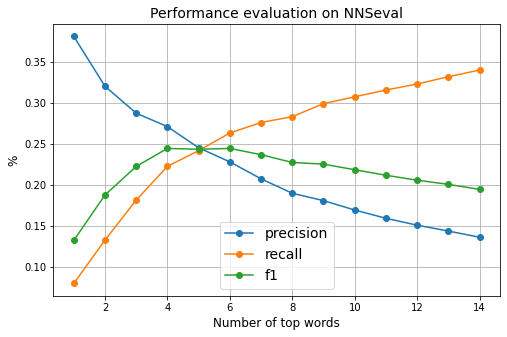

In [30]:
plot_evaluation_curves(final_suggestions, 15)

In [31]:
count_no_matches

54

Now for some free exploring, unrelated to datasets:

In [32]:
def replace_word(sentence, candidate, n):
    word_emb = embeddings_index[candidate]  
    dists = compute_all_distances(all_embeddings, word_emb)
    cosines = compute_all_cosines(all_embeddings, word_emb)
    ind_dist = np.argsort(dists)
    ind_cos = np.argsort(cosines)[::-1]
    ind = np.union1d(ind_dist[1:n], ind_cos[1:n])
    limited_vocab = vocab[ind]

    filtered_pos = filter_by_pos(sentence, candidate, limited_vocab)
    filtered_lemma = filter_by_lemma(candidate, filtered_pos)
    filter_freq, filter_words = bert_rated_sugg(sentence, candidate, filtered_lemma)
    top_word = filter_words[0]
    top_sentence = sentence.replace(candidate, top_word)
    print(top_sentence)
    print(filter_words[:10])

In [45]:
n = 100
sentence = 'The cat perched on the mat'
candidate = 'perched'
replace_word(sentence, candidate, n)

The cat sat on the mat
['sat', 'stood', 'elevated', 'landed', 'situated', 'spotted', 'placed', 'left']


In [46]:
n = 100
sentence = 'You shall not pass!'
candidate = 'shall'
replace_word(sentence, candidate, n)

You will not pass!
['will', 'may', 'must', 'should', 'can', 'ought', 'would', 'could', 'might']


In [47]:
n = 100
sentence = 'Nobody expects the Spanish inquisition'
candidate = 'inquisition'
replace_word(sentence, candidate, n)

Nobody expects the Spanish tribunal
['tribunal', 'torture', 'witch', 'medieval', 'inquiry', 'holocaust', 'institute', 'judicial', 'investigation', 'madness']
